In [5]:
#import the packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#we first get the functions we need


#execution
from execution import optimal_execution,total_cost,price_spread


#read the data
dailyVol = pd.read_csv('Data/dailyVolDf.csv')
priceData = pd.read_csv('Data/PriceData.csv')
volumeData = pd.read_csv('Data/VolumeData.csv')
volumePredictions = pd.read_csv('Data/VolumePredictions.csv')

dailyVol.set_index(priceData['stock_name'],inplace=True)
priceData.set_index(['stock_name'],inplace=True)
volumeData.set_index(['stock_name'],inplace=True)

In [6]:
def cum_sum(arr):
    result = [0]

    for x in arr:
        result.append(x + result[-1])

    return np.array(result)

def mean_squared_residual(tick,volumePredictions,volumeData):
    sq_errors = []
    for date in range(len(volumeData.columns) // 13):
        volume_date = volumeData[volumeData.columns[(int(date) - 1) * 13: int(date) * 13]].loc[tick] 
        volume_date_fraction = cum_sum(volume_date / np.sum(volume_date))
        prediction_date_fraction = np.insert(np.array(volumePredictions[(volumePredictions['stock_name'] == tick) & (volumePredictions['day'] == int(date))]['cumulative_ratio']),0,0)

        sq_errors.append(np.mean(np.square(volume_date_fraction - prediction_date_fraction)))
    
    return np.mean(np.array(sq_errors)[~np.isnan(sq_errors)])
        


price per share: 0.0005713960971616029
as a percentage: 0.010586880%

actual trading cost: 0.0002863903870854046, actual spread cost: -0.010365454484886722
actual cost per share: -0.010079064097801318


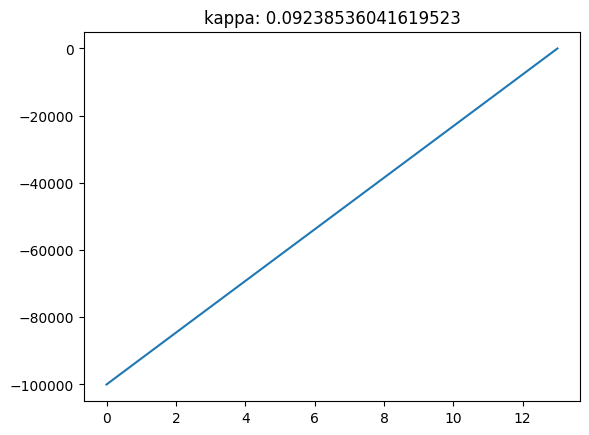

In [11]:
#for the price of a guaranteed execution, we specify a name, amount of shares, and a date

tick = 'SUNW'
X = -100000

#we use a ten day lookback period for volitality estimation, so the date should be 10 days onward
date = '16'

Lambda = 10**-6
eta = 0.142
T = 1
N = 13
arrival_price = priceData[priceData.columns[(int(date) - 1) * 13]][tick]
prices =  priceData[priceData.columns[(int(date) - 1) * 13: (int(date)) * 13 ]].loc[tick]
sigma = dailyVol[date][tick]  * arrival_price #sigma needs to be adjusted by prices
ADV = np.mean(volumeData.loc[tick][volumeData.loc[tick] != 0]) * 13 * arrival_price # adjusted with price
V_var = mean_squared_residual(tick,volumePredictions,volumeData)
EVk = np.insert(np.array(volumePredictions[(volumePredictions['stock_name'] == tick) & (volumePredictions['day'] == int(date))]['cumulative_ratio']),0,0)
EVk2 = np.square(EVk) + V_var
actual_volume = volumeData[volumeData.columns[(int(date) - 1) * 13: int(date) * 13]].loc[tick] 

#compute the risk adjusted cost (price) per share
print('price per share: %s'%price_spread(sigma,X,ADV,EVk,EVk2,eta,T,N,Lambda))
print('as a percentage: %.9f%%'%(price_spread(sigma,X,ADV,EVk,EVk2,eta,T,N,Lambda) / arrival_price * 100))

actual_cost = total_cost(optimal_execution(EVk,X,Lambda,sigma,ADV,eta,T,N),sigma,ADV,prices,actual_volume,eta,T,N)
print()
print('actual trading cost: %s, actual spread cost: %s'%(actual_cost[0] / np.abs(X), actual_cost[1] / np.abs(X)))
print('actual cost per share: %s'%(np.sum(actual_cost) / np.abs(X)))

#the trading path used in this pricing:

plt.title('kappa: %s'% np.sqrt(Lambda * sigma / (1.5 * 0.142 * np.sqrt(1 / ADV))))
plt.plot(range(14),optimal_execution(EVk,X,Lambda,sigma,ADV,eta,T,N))
plt.show()

price per share: 0.0005687563857635574
as a percentage: 0.010566121%

actual trading cost: 0.0002877812685937953, actual spread cost: 0.0027967088233097456
actual cost per share: 0.003084490091903541


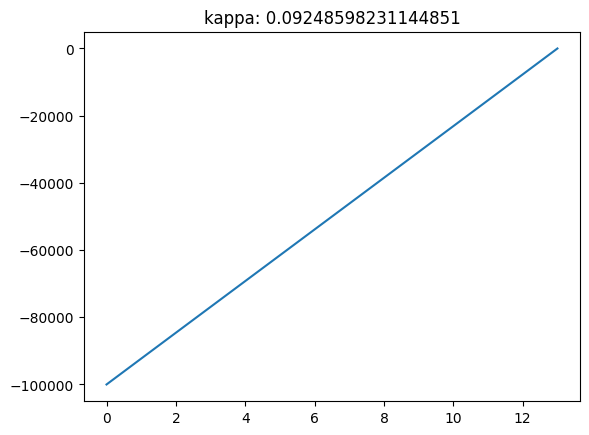

In [9]:
#we see for another date
date = '12'

Lambda = 10**-6
eta = 0.142
T = 1
N = 13
arrival_price = priceData[priceData.columns[(int(date) - 1) * 13]][tick]
prices =  priceData[priceData.columns[(int(date) - 1) * 13: (int(date)) * 13 ]].loc[tick]
sigma = dailyVol[date][tick]  * arrival_price #sigma needs to be adjusted by prices
ADV = np.mean(volumeData.loc[tick][volumeData.loc[tick] != 0]) * 13 * arrival_price # adjusted with price
V_var = mean_squared_residual(tick,volumePredictions,volumeData)
EVk = np.insert(np.array(volumePredictions[(volumePredictions['stock_name'] == tick) & (volumePredictions['day'] == int(date))]['cumulative_ratio']),0,0)
EVk2 = np.square(EVk) + V_var
actual_volume = volumeData[volumeData.columns[(int(date) - 1) * 13: int(date) * 13]].loc[tick] 

#compute the risk adjusted cost (price) per share
print('price per share: %s'%price_spread(sigma,X,ADV,EVk,EVk2,eta,T,N,Lambda))
print('as a percentage: %.9f%%'%(price_spread(sigma,X,ADV,EVk,EVk2,eta,T,N,Lambda) / arrival_price * 100))

actual_cost = total_cost(optimal_execution(EVk,X,Lambda,sigma,ADV,eta,T,N),sigma,ADV,prices,actual_volume,eta,T,N)
print()
print('actual trading cost: %s, actual spread cost: %s'%(actual_cost[0] / np.abs(X), actual_cost[1] / np.abs(X)))
print('actual cost per share: %s'%(np.sum(actual_cost) / np.abs(X)))

#the trading path used in this pricing:

plt.title('kappa: %s'% np.sqrt(Lambda * sigma / (1.5 * 0.142 * np.sqrt(1 / ADV))))
plt.plot(range(14),optimal_execution(EVk,X,Lambda,sigma,ADV,eta,T,N))
plt.show()

The low level of kappa suggests that the risk of adverse price movement is relatively low comparing to the trading cost, so the optimal path focus more on the trading cost optimization rather than varaince.

On average the actual cost per share revolve around our risk adjusted cost. 

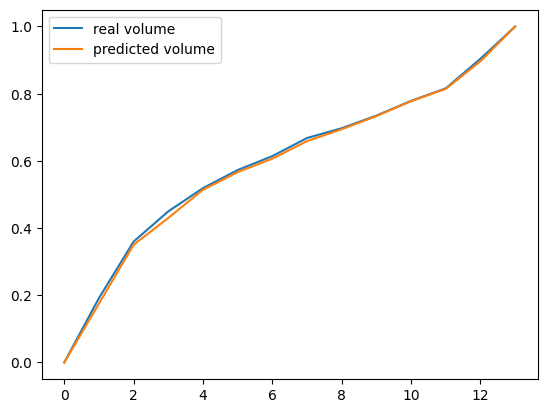

In [10]:
plt.plot(range(14),cum_sum(actual_volume / np.sum(actual_volume)),label = 'real volume')
plt.plot(range(14),EVk,label = 'predicted volume')
plt.legend()
plt.show()